In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
from typing import List
from numpy.typing import NDArray

In [3]:
class Point():
    """General point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, centre:complex=None) -> None:
        if centre:
            self.centre:complex = centre
        else:
            self.centre:complex = np.random.random() + 1j*np.random.random()

    def distance(self, other:'Point'):
        return abs(self.centre - other.centre)

In [4]:
class Particle(Point):
    """Sources to calculate multipoles from

    Inherits from Point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    charge : float
        charge associated with the point, real number,
        if no argument given, random in range [-1,1)

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, charge:float=None, centre:complex=None) -> None:
        super().__init__(centre)
        if charge:
            self.charge:float = charge
        else:
            # random in range -1 to 1
            self.charge:float = 2*np.random.random() - 1

In [12]:
class Cell(Point):
    """Class for cells that tree constructed from
    
    Inherits from Point
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    size : float
        size of the side of a box
    level : int
        level number (start at 0) in tree
    parent : Cell
        the parent cell


    n_particles : int
        number of particles in cell
    particles : list of Particle
        list of particles contained

    bit_children : bitwise
        child locations eg, child in 2 and 4 is 1010
    children : array of Cells
        cells children
    
    precision : int
        number of terms in multipole expansion
    multipole : NDArray of complex
        coefficients of the multipole expansion
    local : NDArray of complex
        coefficients of the multipole local

    Methods
    -------
    distance : float
        return distance to another point
    create_multipole : None
        generate multipole due to bodies contained
    """

    def __init__(self,
                 centre:complex,
                 size:float,
                 precision:int=1,
                 parent:'Cell'=None) -> None:
        
        super().__init__(centre)

        self.size:float = size
        if parent:
            self.level:int = parent.level + 1
        else:
            self.level:int = 0

        self.parent:'Cell' = parent

        self.n_particles:int = 0
        self.particles:List[Particle] = []

        self.bit_children:int = 0 # 0000, bitwise operations
        self.children:NDArray[+'Cell'] = np.zeros(4, dtype=object)

        self.precision:int = precision
        self.multipole:NDArray[+complex] = np.zeros(precision, dtype=complex)
        self.local:NDArray[+complex] = np.zeros(precision, dtype=complex)

    def __repr__(self) -> str:
        return f'Cell lvl{self.level}: {self.centre} {self.n_particles} particle'
    
    def print_tree(self, level=0):
        print('\t'*level, f'({int(self.centre.real*2**(level) -0.5)},{int(self.centre.imag*2**(level) -0.5)})', self)
        for child in self.children:
            if child:
                child.print_tree(level+1)


    def _add_child(self, quadrant:int, cells:List['Cell']):
        """Add new child in given octant
        
        Create relevant references in cell object, and in cells list
        """

        # bitwise operations to determine if left or right
        #   then if up or down, and apply appropriate shift
        # (if both yeild 0, then bottom left, otherwise relative to there) 
        child_centre =  self.centre + 0.25*self.size * (
                (-1+2*(quadrant & 1)) + 1j*(-1+2*((quadrant & 2)>>1)))
        
        # add child to array of children, in correct location
        self.children[quadrant] = Cell(child_centre,
                                        self.size/2,
                                        self.precision,
                                        self)
        self.bit_children += (1<<quadrant)

        # add child to cells list
        cells.append(self.children[quadrant])


    def _particle_quadrant(self, particle_centre:complex) -> int:
        """Return int 0 to 3 corresponding to the particles quadrant"""
        return (particle_centre.real > self.centre.real) | \
                    (particle_centre.imag > self.centre.imag)<<1 # int 0 to 3
    

    def _split_cell(self, n_crit:int, max_level:int, cells:List['Cell']):
        """Splits self, distributing children and creating cells as needed"""

        for particle in self.particles:
            quadrant = self._particle_quadrant(particle.centre)

            # check for no child child
            #   if there is no match between the bit children and the quadrant bit
            if not self.bit_children & (1 << quadrant):
                self._add_child(quadrant, cells)

            # add particle to child
            self.children[quadrant].add_particle(particle,n_crit,max_level,cells)

        
    def add_particle(self, particle:Particle, n_crit:int, max_level:int, cells:List['Cell']):
        self.n_particles += 1
        self.particles.append(particle)

        if (self.n_particles < n_crit) or (self.level == max_level): # still leaf or max level
            return
        
        elif self.n_particles == n_crit: # just become not leaf
            self._split_cell(n_crit, max_level, cells)

        else: # already branch
            quadrant = self._particle_quadrant(particle.centre)

            # check for no child child
            #   if there is no match between the bit children and the quadrant bit
            if not self.bit_children & (1 << quadrant):
                self._add_child(quadrant, cells)

            # add particle to child
            self.children[quadrant].add_particle(particle,n_crit,max_level,cells)


    def _calculate_multipole(self) -> None:
        """Explicit calculation of multipole coeffs due to constituent particles"""
        charges = np.array([particle.charge for particle in self.particles])
        positions = np.array([particle.centre for particle in self.particles])
        # Q
        self.multipole[0] = np.sum(charges)
        # a_k
        for k in range(1, len(self.multipole)):
            self.multipole[k] = np.sum(-charges * (positions-self.centre)**k / k)
    
    def _M2M(self, child:'Cell') -> None:
        """Perform M2M method"""

        z0 = child.centre - self.centre

        self.multipole[0] += child.multipole[0]

        for l in range(1, self.precision):
            # bl = - child.multipole[0] * z0**l / l
            # for k in range(1,l+1):
            #     bl += child.multipole[k] * z0**(l-k) * sp.special.binom(l-1,k-1)
            # self.multipole[l] += bl

            self.multipole[l] += \
                -(child.multipole[0] * z0**l / l) \
                    + np.sum(child.multipole[1:l+1] \
                             * z0**(l-np.arange(1,l+1,1)) \
                             * sp.special.binom(l-1, np.arange(0,l,1)))

    def get_multipole(self) -> None:
        """Either use M2M or calculation to get multipole of cell"""

        if self.bit_children == 0: # leaf
            self._calculate_multipole()
        else: # branch
            for child in self.children:
                if child:
                    self._M2M(child)

    # def get_nearest_neighbours(self) -> List['Cell']:
    #     """Traverses down tree to generate arrays of nearest neighbours 
    #     for each Cell in the tree
    #     """
    #     self.nearest_neighbours:NDArray[+'Cell'] = np.zeros(8, dtype=object)




In [24]:
num_particles = 30
particles = [ Particle() for _ in range(num_particles) ]
p=4

root = Cell(0.5*(1+1j),10,p)
cells = [root]

# particles = []
# particles.append(Particle(1, 0.25*(1+1j)))
# particles.append(Particle(2, 0.25*(3+1j)))
# particles.append(Particle(-2, 0.25*(1+3j)))
# particles.append(Particle(-3, 0.25*(3+3j)))

for particle in particles:
    root.add_particle(particle,
                      n_crit=2,
                      max_level=100,
                      cells=cells)
    
root.print_tree()


 (0,0) Cell lvl0: (0.5+0.5j) 30 particle
	 (-4,-4) Cell lvl1: (-2-2j) 6 particle
		 (-3,-3) Cell lvl2: (-0.75-0.75j) 6 particle
			 (-1,-1) Cell lvl3: (-0.125-0.125j) 6 particle
				 (2,2) Cell lvl4: (0.1875+0.1875j) 6 particle
					 (10,0) Cell lvl5: (0.34375+0.03125j) 1 particle
					 (0,10) Cell lvl5: (0.03125+0.34375j) 1 particle
					 (10,10) Cell lvl5: (0.34375+0.34375j) 4 particle
						 (16,16) Cell lvl6: (0.265625+0.265625j) 1 particle
						 (26,16) Cell lvl6: (0.421875+0.265625j) 2 particle
							 (58,28) Cell lvl7: (0.4609375+0.2265625j) 1 particle
							 (58,38) Cell lvl7: (0.4609375+0.3046875j) 1 particle
						 (26,26) Cell lvl6: (0.421875+0.421875j) 1 particle
	 (5,-4) Cell lvl1: (3-2j) 6 particle
		 (6,-3) Cell lvl2: (1.75-0.75j) 6 particle
			 (8,-1) Cell lvl3: (1.125-0.125j) 6 particle
				 (12,2) Cell lvl4: (0.8125+0.1875j) 6 particle
					 (20,0) Cell lvl5: (0.65625+0.03125j) 3 particle
						 (46,-3) Cell lvl6: (0.734375-0.046875j) 1 particle
						 (36,6) Cell 

In [19]:
cell = Cell(0.5+0.5j, 1, 4)
new_list = [cell]

cell._add_child(3, new_list)

new_list[-1].centre

(0.75+0.75j)

In [15]:
for cell in cells:
    cell.multipole = np.zeros(p,dtype=complex)

root._calculate_multipole()
direct = root.multipole

root.multipole = np.zeros(p, dtype=complex)

for cell in reversed(cells):
    cell.get_multipole()
M2M = root.multipole

err = (M2M - direct)/abs(direct)
print(direct)
print(M2M)
print(err)
np.sum(abs(err))

[ 6.28953764+0.j          2.17997669-0.43340537j -0.09758794-0.15225715j
 -0.06879123+0.21673445j]
[ 6.28953764+0.j          2.17997669-0.43340537j -0.09758794-0.15225715j
 -0.06879123+0.21673445j]
[ 1.41215217e-16+0.00000000e+00j  3.99604758e-16+1.99802379e-16j
  2.67814640e-14+4.38939753e-14j -1.70520244e-13-7.99504365e-14j]


2.403398792134001e-13

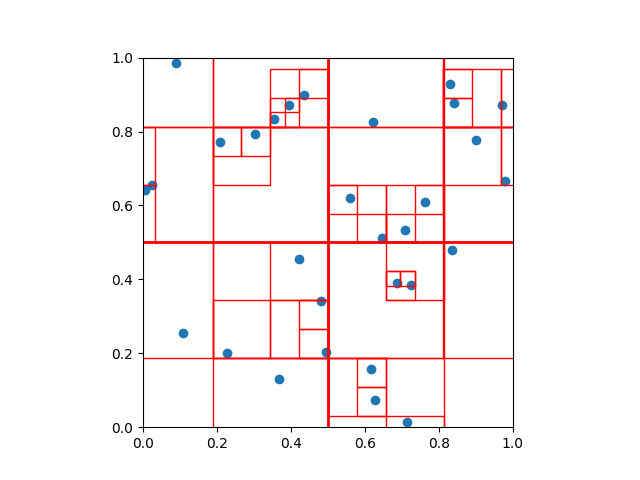

In [25]:
fig,ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

points = [source.centre for source in particles]
X,Y = np.real(points), np.imag(points)

ax.scatter(X,Y)

import matplotlib.patches as patches

def draw_rectangles(cell:Cell):
    corner = cell.centre - cell.size*(0.5+0.5j)
    p = patches.Rectangle((corner.real,corner.imag),cell.size,cell.size, fill=False, color='red')
    ax.add_patch(p)
    if cell.bit_children == 0:
        return
    else:
        for child in cell.children:
            if child:
                draw_rectangles(child)

draw_rectangles(root)

plt.show()

In [40]:
# particles = []
# particles.append(Particle(1, 0.25*(1+1j)))
# particles.append(Particle(2, 0.25*(3+1j)))
# particles.append(Particle(-2, 0.25*(1+3j)))
# particles.append(Particle(-3, 0.25*(3+3j)))

In [243]:
"""Shows numpy method is equivalent to explicit"""

z0 = -1+2j
precision = 3

multipole_for = np.zeros(precision, dtype=complex)
multipole_np = np.zeros(precision, dtype=complex)

child_multipole_real = np.random.random(precision)
child_multipole_imag = np.random.random(precision)
child_multipole = child_multipole_real + 1j*child_multipole_imag
child_multipole[0] = child_multipole[0].real

multipole_for[0] += child_multipole[0]
multipole_np[0] += child_multipole[0]

for l in range(1, precision):
    bl = - child_multipole[0] * z0**l / l
    for k in range(1,l+1):
        bl += child_multipole[k] * z0**(l-k) * sp.special.binom(l-1,k-1)
    multipole_for[l] += bl

    multipole_np[l] += \
    -(child_multipole[0] * z0**l / l) \
        + np.sum(child_multipole[1:l+1] \
                    * z0**(l-np.arange(1,l+1,1)) \
                    * sp.special.binom(l-1, np.arange(0,l,1)))

    
print(multipole_for)
print(multipole_np)

[0.59307307+0.j         1.09098377-1.04759056j 1.06862753+2.73010138j]
[0.59307307+0.j         1.09098377-1.04759056j 1.06862753+2.73010138j]
